In [2]:
import numpy as np
from fit_types import *
from tc_utils import *
material = "SS304" # Select the Material ID

In [3]:
# Load the compilation file
TCdata = np.loadtxt("..\\thermal_conductivity_compilation_2024-04-16.csv", dtype=str, delimiter=',')
headers = TCdata[0]

mat_names = TCdata[:,0]
mat_row = TCdata[int(np.argwhere(mat_names == material))]

In [4]:
print(mat_row)
num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
fit_params = mat_row

['SS304' 'loglog' '0.385' '1672.000' '3.953' '2.23367e-07' '-5.04296e-05'
 '3.01386e-03' '6.96502e-02' '0.00e+00' '0.00e+00' '0.00e+00' '0.00e+00'
 '0.00e+00' '1.19786e+02' '3.42081e-02' '-1.71132e-01' '6.23536e-01'
 '1.49213e-01']


In [5]:
parameter_dict = dict(zip(headers, fit_params))
print(parameter_dict)

{'Material Name': 'SS304', 'Fit Type': 'loglog', 'Low Temp': '0.385', 'High Temp': '1672.000', 'Perc Err': '3.953', 'a': '2.23367e-07', 'b': '-5.04296e-05', 'c': '3.01386e-03', 'd': '6.96502e-02', 'e': '0.00e+00', 'f': '0.00e+00', 'g': '0.00e+00', 'h': '0.00e+00', 'i': '0.00e+00', 'erf param': '1.19786e+02', 'A': '3.42081e-02', 'B': '-1.71132e-01', 'C': '6.23536e-01', 'D': '1.49213e-01'}


In [6]:
def zero_filter(arr):
    filtered_arr = []
    for i in range(len(arr)):
        if arr[i] == 0:
            if i == 0 and arr[i + 1] != 0:
                filtered_arr.append(arr[i])
            elif arr[i - 1] != 0 and arr[i + 1] != 0:
                print(i)
                filtered_arr.append(arr[i])
        else:
            filtered_arr.append(arr[i])

    filtered_arr = np.array(filtered_arr)
    return filtered_arr

In [7]:
# T = np.linspace(float(parameter_dict["Low Temp"]), float(parameter_dict["High Temp"]), 10000)
T = np.logspace(np.log10(float(parameter_dict["Low Temp"])),np.log10(float(parameter_dict["High Temp"])),10000)

In [8]:
low_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_low -1, "l")]
hi_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_hi, "H")]
erf_param = float(parameter_dict["erf param"])

print(low_param)
low_param = zero_filter(low_param)
hi_param = zero_filter(hi_param)

print(low_param, hi_param, erf_param)

k = loglog_func(T, low_param, hi_param, erf_param)


print(loglog_func(260, low_param, hi_param, erf_param))

[2.23367e-07, -5.04296e-05, 0.00301386, 0.0696502, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 2.23367e-07 -5.04296e-05  3.01386e-03  6.96502e-02] [ 0.0342081 -0.171132   0.623536   0.149213 ] 119.786
13.765012720563208


In [9]:
from scipy.integrate import trapz, simpson
def definite_integral(x, y, start_x, end_x):
    indices = np.where((x >= start_x) & (x <= end_x))
    return trapz(y[indices], x[indices], 0.01)

def definite_integral_simpson(x, y, start_x, end_x):
    indices = np.where((x >= start_x) & (x <= end_x))
    return simpson(y[indices], x[indices], 0.01)
# Example usage:
x_values = T  # Example x values
y_values = k  # Example y values (squared values of x)
start_x = 169.2  # Start x value for integration
end_x = 260  # End x value for integration
result = definite_integral(x_values, y_values, start_x, end_x)
print("Definite integral between", start_x, "and", end_x, ":", result)



Definite integral between 169.2 and 260 : 1156.5949683888346


NIST Fit and Integral

In [10]:
# Now pull the same data from the NIST comp file
TCdata = np.loadtxt("..\\thermal_conductivity_compilation_NIST_2024-04-16.csv", dtype=str, delimiter=',')

headers = TCdata[0]
mat_names = TCdata[:,0]
mat_row = TCdata[int(np.argwhere(mat_names == material))]

In [11]:
num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
fit_params = mat_row
fit_params = np.char.replace(fit_params, "^", "0")

In [12]:
parameter_dict = dict(zip(headers, fit_params))
print(parameter_dict)

{'Material Name': 'SS304', 'Fit Type': 'NIST-1', 'Low Temp': '4.000', 'High Temp': '300.000', 'Perc Err': '2.0', 'a': '-1.40870e+00', 'b': '1.39820e+00', 'c': '2.54300e-01', 'd': '-6.26000e-01', 'e': '2.33400e-01', 'f': '4.25600e-01', 'g': '-4.65800e-01', 'h': '1.65000e-01', 'i': '-1.99000e-02'}


In [13]:
params_NIST = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_low+1, "l")]
params_NIST = np.flip(params_NIST)
print(np.poly1d(params_NIST))
k_Nist = NIST1(T, params_NIST)

         8         7          6          5          4         3
-0.0199 x + 0.165 x - 0.4658 x + 0.4256 x + 0.2334 x - 0.626 x
           2
 + 0.2543 x + 1.398 x - 1.409


In [14]:
# Example usage:
x_values = T  # Example x values
y_values = k_Nist  # Example y values (squared values of x)
start_x = 169.2  # Start x value for integration
end_x = 260  # End x value for integration
result = definite_integral(x_values, y_values, start_x, end_x)
def integrand(x):
    return 10**(-0.0199*np.log10(x)**8 + 0.165*np.log10(x)**7 - 0.4658*np.log10(x)**6 + 0.4256*np.log10(x)**5 + 0.2334*np.log10(x)**4 - 0.626*np.log10(x)**3 + 0.2543*np.log10(x)**2 + 1.398*np.log10(x) - 1.409)
# Perform the definite integral
from scipy.integrate import quad
result2, error = quad(integrand, start_x, end_x)
result3 = definite_integral_simpson(x_values, y_values, start_x, end_x)

print("Definite integral between", start_x, "and", end_x, ":", result, result2, result3)

Definite integral between 169.2 and 260 : 1180.535040955626 1180.3457218313351 1180.5350477232234


New fit by Ray Radebaugh

In [15]:
rrfit = np.loadtxt(f"lib\\{material}\\OTHERFITS\\{material}.csv", dtype=str, delimiter=',')
headers = rrfit[0]
fit_params = rrfit[-1]


num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
print(num_low)
parameter_dict = dict(zip(headers, fit_params))
print(parameter_dict)


3
{'Fit Type': 'loglog', 'Low Temp': '0.300', 'High Temp': '1707.000', 'Perc Err': '0.000', 'a': '7.11786e-02', 'b': '3.45290e-03', 'c': '-6.00000e-05', 'A': '-4.97617e+00', 'B': '8.31635e+00', 'C': '-3.59726e+00', 'D': '7.16110e-01', 'E': '-2.75070e-01', 'erf param': '3.20000e+01'}


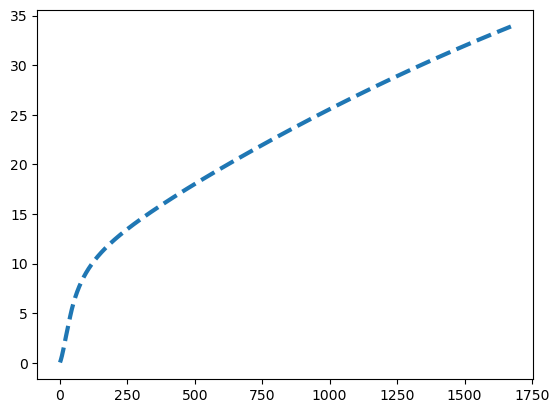

In [16]:
low_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_low, "l")]
hi_param = [float(parameter_dict[letter]) for letter in generate_alphabet_array(num_hi, "H")]
erf_param = float(parameter_dict["erf param"])

low_param = zero_filter(low_param)
hi_param = zero_filter(hi_param)

kRR = RRadebaugh3(T, low_param, hi_param, erf_param)
plt.plot(T, kRR, linestyle="--", linewidth = 3, label="Radebaugh")
plt.show()

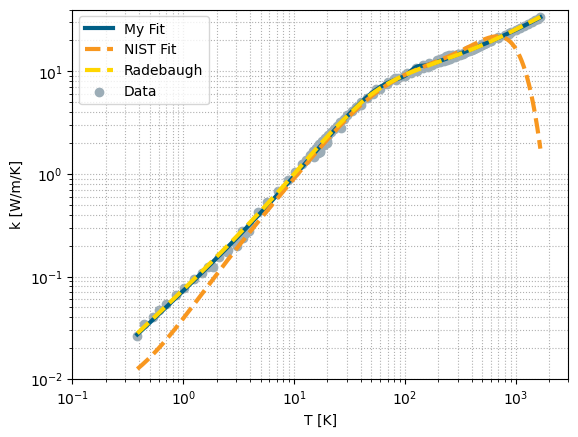

In [17]:
big_data, data_dict = parse_raw(material, f"lib\{material}\RAW", plots=False)
T_data = big_data[:,0]
k_data = big_data[:,1]

from matplotlib.colors import LinearSegmentedColormap

# colors = [(0, '#333f48'), (0.5, '#d6d2c4'), (1, '#9cadb7'), (0, '#005f86'), (0.5, '#00a9b7'), (1, '#579d42'), (0, '#a6cd57'), (0.5, '#ffd600'), (1, '#f8971f')]
colors = ['#333f48', '#d6d2c4', '#9cadb7', '#005f86', '#00a9b7', '#579d42', '#a6cd57', '#ffd600', '#f8971f']

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


plt.plot(T, k, color=colors[3], linestyle="-", linewidth = 3, label="My Fit")
plt.plot(T, k_Nist, color=colors[-1], linestyle="--", linewidth = 3, label="NIST Fit")
plt.plot(T, kRR, color=colors[-2], linestyle="--", linewidth = 3, label="Radebaugh")
# plt.plot(T_data, k_data, '.', color=colors[2], markersize=9, alpha=0.3, label="data")
plt.scatter(T_data, k_data, c=colors[2], label = "Data")
plt.ylabel("k [W/m/K]")
plt.xlabel("T [K]")
plt.legend()
plt.xlim(0.1, 3000)
plt.ylim(0.01, 40)
plt.semilogy()
plt.semilogx()

plt.grid(True, which="both", linestyle=':')

plt.show()


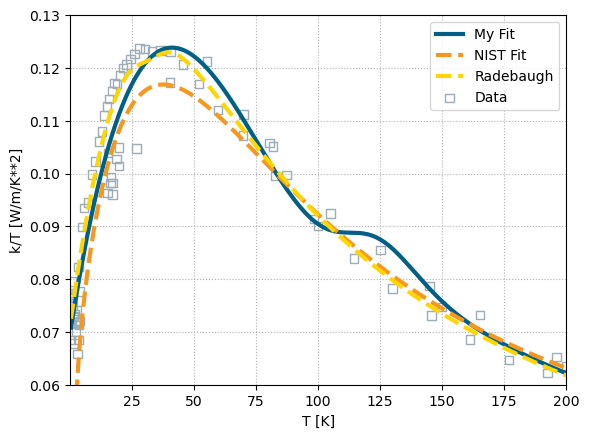

In [18]:
plt.plot(T, k/T, color=colors[3], linestyle="-", linewidth = 3, label="My Fit")
plt.plot(T, k_Nist/T, color=colors[-1], linestyle="--", linewidth = 3, label="NIST Fit")
plt.plot(T, kRR/T, color=colors[-2], linestyle="--", linewidth = 3, label="Radebaugh")
# plt.plot(T_data, k_data, '.', color=colors[2], markersize=9, alpha=0.3, label="data")
plt.scatter(T_data, k_data/T_data, edgecolors=colors[2], label = "Data", marker="s", facecolors='none')
plt.ylabel("k/T [W/m/K**2]")
plt.xlabel("T [K]")
plt.legend()
plt.xlim(0.1, 200)
plt.ylim(0.06, .13)
# plt.semilogy()
# plt.semilogx()

plt.grid(True, which="both", linestyle=':')

plt.show()

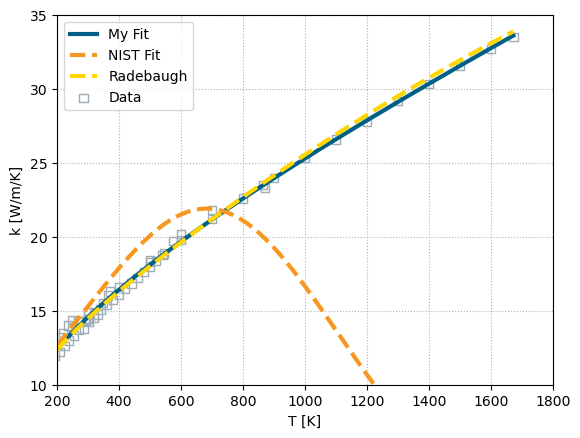

In [19]:
plt.plot(T, k, color=colors[3], linestyle="-", linewidth = 3, label="My Fit")
plt.plot(T, k_Nist, color=colors[-1], linestyle="--", linewidth = 3, label="NIST Fit")
plt.plot(T, kRR, color=colors[-2], linestyle="--", linewidth = 3, label="Radebaugh")
# plt.plot(T_data, k_data, '.', color=colors[2], markersize=9, alpha=0.3, label="data")
plt.scatter(T_data, k_data, edgecolors=colors[2], label = "Data", marker="s", facecolors='none')
plt.ylabel("k [W/m/K]")
plt.xlabel("T [K]")
plt.legend()
plt.xlim(200, 1800)
plt.ylim(10, 35)
# plt.semilogy()
# plt.semilogx()

plt.grid(True, which="both", linestyle=':')

plt.show()

Residual Plots

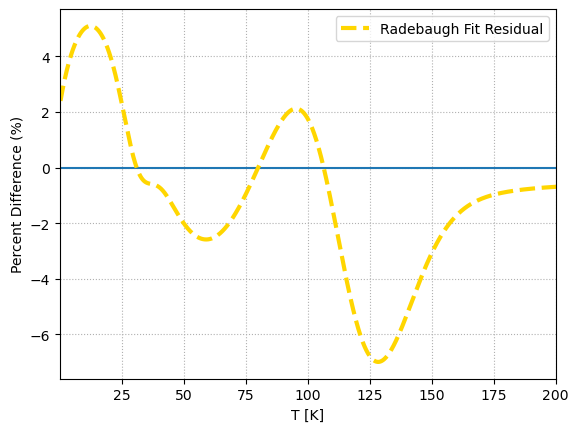

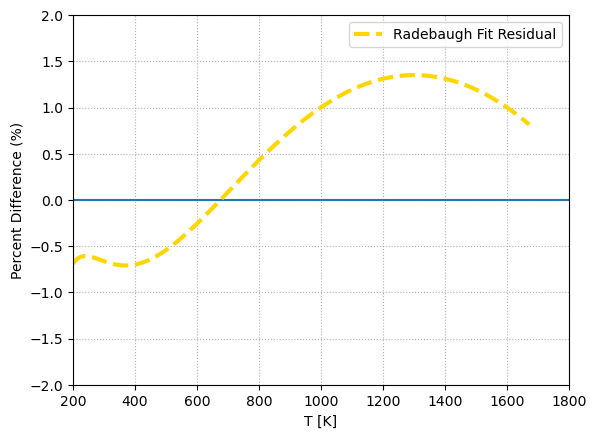

In [24]:
plt.hlines(0, 0.1, 200)
plt.plot(T, ((kRR/T)-(k/T))/(k/T)*100, color=colors[-2], linestyle="--", linewidth = 3, label="Radebaugh Fit Residual")
plt.ylabel("Percent Difference (%)")
plt.xlabel("T [K]")
plt.legend()
plt.xlim(0.1, 200)


plt.grid(True, which="both", linestyle=':')

plt.show()

plt.hlines(0, 200,1800)
plt.plot(T, ((kRR)-(k))/(k)*100, color=colors[-2], linestyle="--", linewidth = 3, label="Radebaugh Fit Residual")
plt.ylabel("Percent Difference (%)")
plt.xlabel("T [K]")
plt.legend()
plt.xlim(200,1800)
plt.ylim(-2,2)

plt.grid(True, which="both", linestyle=':')

plt.show()


In [21]:
def power_load(area, length, conInt):
    return area/length*conInt

od = 35.625*0.0254 # m
l = 29*0.0254 # m
mat_thickness = 0.0625*0.0254

area = np.pi*((od/2)**2-((od/2)-mat_thickness)**2)

print(area, area/l, result)
power_load(area, l, result)


0.004504946181351276 0.006115865030343845 1180.535040955626


7.219992974076053